In [1]:
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

In [2]:
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.utils.validation import check_is_fitted

In [3]:
def wrangle(db_path): 

    conn = sqlite3.connect(db_path) 
    query = """

        select distinct(id_map.building_id) as b_id, building_structure.*, building_damage.damage_grade
        from id_map 
        join building_structure on id_map.building_id = building_structure.building_id
        join building_damage on id_map.building_id = building_damage.building_id
        where id_map.district_id = 36 
"""
    
    df = pd.read_sql(query,conn,index_col = 'b_id') 
    drop_cols = [col for col in df.columns if 'post_eq' in col] 
    
    df['damage_grade'] = df['damage_grade'].str[-1].astype(int) 
    df['severe_damage'] = (df['damage_grade'] > 3).astype(int) 

    drop_cols.append('damage_grade') 
    drop_cols.append('count_floors_pre_eq') 

    drop_cols.append('building_id') 

    df.drop(columns=drop_cols, inplace=True) 

    return df 

    


In [4]:
df = wrangle("C:\\Users\\kache\\python linus\\nepal_eq.db") 
df.head()

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,severe_damage
b_id,,,,,,,,,,,,
3.601060e+11,4,Mud mortar-Stone/Brick,Mud,18,Flat,TImber/Bamboo-Mud,Rectangular,280,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
3.601060e+11,15,Mud mortar-Stone/Brick,Mud,18,Flat,Not applicable,Rectangular,120,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone,1
3.601070e+11,25,Mud mortar-Stone/Brick,Mud,14,Flat,TImber/Bamboo-Mud,Rectangular,300,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
3.601070e+11,22,Mud mortar-Stone/Brick,Mud,16,Flat,TImber/Bamboo-Mud,Rectangular,155,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
3.602020e+11,20,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone,1


In [5]:
df.columns

Index(['age_building', 'foundation_type', 'ground_floor_type',
       'height_ft_pre_eq', 'land_surface_condition', 'other_floor_type',
       'plan_configuration', 'plinth_area_sq_ft', 'position', 'roof_type',
       'superstructure', 'severe_damage'],
      dtype='object')

In [6]:
from collections import Counter

In [7]:
Counter(df.severe_damage)

Counter({1: 49661, 0: 28413})

In [8]:
foundation_pivot = pd.pivot_table( 
    df, index = 'foundation_type', values = 'severe_damage', aggfunc='mean'
).sort_values(by='severe_damage')

foundation_pivot


,severe_damage
foundation_type,
RC,0.027134
Bamboo/Timber,0.321429
Cement-Stone/Brick,0.410200
Mud mortar-Stone/Brick,0.684101
Other,0.801020


In [9]:
major, minor = df.severe_damage.value_counts(normalize=True) 

<Figure size 500x300 with 0 Axes>

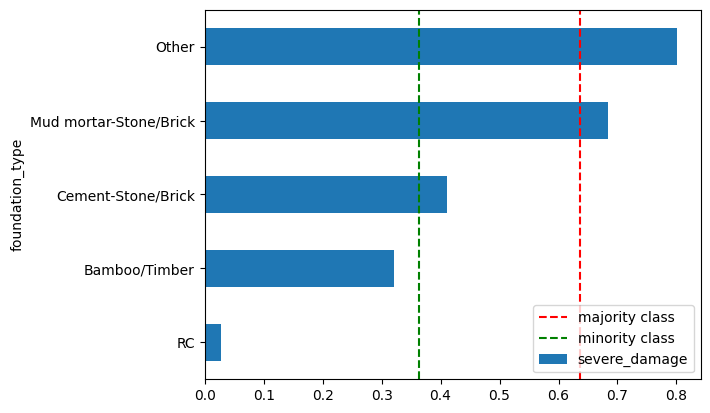

In [10]:
plt.figure(figsize=(5,3))
foundation_pivot.plot(kind='barh')
plt.axvline(
    major, linestyle='--', color='red', label='majority class'
) 
plt.axvline(
    minor, linestyle='--', color='green', label='minority class'
) 
plt.legend(loc= 'lower right') 
plt.show()

In [11]:
df.select_dtypes('object').nunique()

foundation_type            5
ground_floor_type          5
land_surface_condition     3
other_floor_type           4
plan_configuration        10
position                   4
roof_type                  3
superstructure            11
dtype: int64

In [12]:
target = 'severe_damage'
x = df.drop(target, axis=1) 
y = df[target]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=30, test_size=0.2)

In [14]:
acc_baseline = y_train.value_counts(normalize=True).max()
acc_baseline

np.float64(0.636865783954274)

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
model = Pipeline( 
    [('ohe', OneHotEncoder(use_cat_names=True)), 
     ('ss', StandardScaler()), 
     ('1r', LogisticRegression())])

In [17]:
model.fit(x_train, y_train)

Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                                     'land_surface_condition',
                                     'other_floor_type', 'plan_configuration',
                                     'position', 'roof_type',
                                     'superstructure'],
                               use_cat_names=True)),
                ('ss', StandardScaler()), ('1r', LogisticRegression())])

In [18]:
check_is_fitted(model)

In [19]:
model.score(x_train, y_train) 

0.7145167229702685

In [20]:
features = model.named_steps['ohe'].get_feature_names_out()
importances = model.named_steps['1r'].coef_[0] 

In [21]:
importances

array([ 0.05063722,  0.14308037,  0.02107706, -0.22147071,  0.06499292,
       -0.05030562,  0.03933233,  0.07346064, -0.14156978,  0.0419811 ,
        0.01211691,  0.02878147, -0.04173744,  0.00998547,  0.07038675,
       -0.03596504,  0.10698596, -0.08805489, -0.01545525,  0.03188928,
        0.01242845, -0.04349019, -0.05526915, -0.01538288, -0.02645863,
       -0.00274751, -0.01338037,  0.0155816 , -0.01215252,  0.06083172,
       -0.01916572,  0.02318511, -0.00227927, -0.0157271 ,  0.07203941,
        0.03015116, -0.19221063,  0.20441238, -0.2603903 , -0.19855499,
        0.18121259,  0.02207174, -0.07157971, -0.04787916, -0.08598876,
       -0.13386097, -0.0514428 , -0.07700489])

In [22]:
feat_imp = pd.Series( np.exp(importances), index = features).sort_values() 

In [23]:
feat_imp

superstructure_cement_mortar_brick                    0.770751
foundation_type_RC                                    0.801339
superstructure_rc_non_engineered                      0.819915
roof_type_RCC/RB/RBC                                  0.825133
ground_floor_type_RC                                  0.867995
superstructure_rc_engineered                          0.874712
other_floor_type_RCC/RB/RBC                           0.915711
superstructure_cement_mortar_stone                    0.917605
superstructure_other                                  0.925885
superstructure_mud_mortar_brick                       0.930922
plan_configuration_Multi-projected                    0.946230
superstructure_bamboo                                 0.949858
foundation_type_Bamboo/Timber                         0.950939
superstructure_timber                                 0.953249
plan_configuration_L-shape                            0.957442
land_surface_condition_Flat                           0

<Axes: >

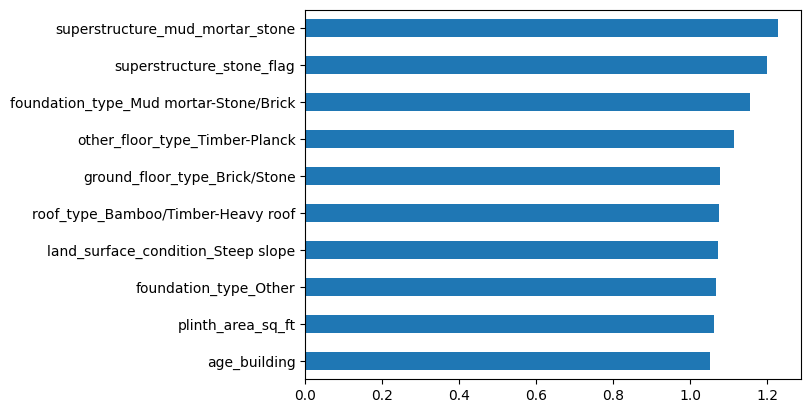

In [24]:
feat_imp.tail(10).plot(kind='barh')

<Axes: >

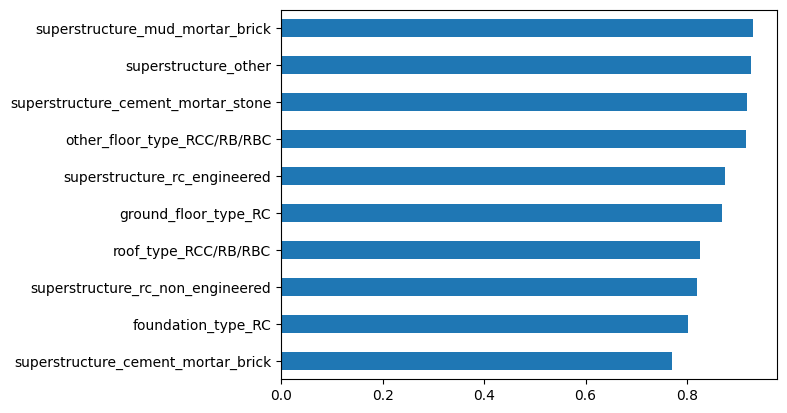

In [25]:
feat_imp.head(10).plot(kind='barh')

In [26]:
import pickle

In [27]:
with open('nepal_model.pkl', 'wb') as f:
    pickle.dump(model, f)